<center><h2>Deep Learning - A.A. 2021-2022</h2></center>
<center><h3>Generative Models: Variational Autoencoders (VAE) e Generative Adversarial Networks (GAN)</h3></center>

In questo laboratorio vedremo due diversi tipi di modelli generativi: i Variational Autoencoders (VAE) e le Generative Adversarial Networks (GAN). Entrambi questi modelli permettono di modellare la distribuzione di probabilità dei dati $P(X)$ e di estrarre (sampling) o generare elementi $x \sim P(X)$ dalla distribuzione modellata. Le applicazioni di questi modelli sono molteplici. La capacità di generare dati appartenenti alla distribuzione studiata può essere di per se utile. Ad esempio le GAN e modelli da essi derivati vengono utilizzati per generare volti di persone non esistenti o per cambiare alcune caratteristiche (ad esempio il sesso) di volti già esistenti. Generare nuovi dati che seguono una certa distribuzione può essere utile anche per fare data augmentation (generare elementi plausibili per fare training di altri modelli). Sia i VAE che opportune variazioni delle GAN permettono di effettuare unsupervised representation learning, stabilendo di fatto un mapping tra dei vettori compatti appartenenti a una distribuzione nota (es. la distribuzione Normale) e i dati appartenenti alla distribuzione considerata.

In [1]:
import torch
import random
import numpy as np
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn import functional as F
import lib
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import os
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from pytorch_lightning.core import LightningModule
from pytorch_lightning.trainer import Trainer
import pytorch_lightning as pl
from torchvision.utils import save_image, make_grid
import torchvision
from collections import OrderedDict
from pytorch_lightning.loggers import TensorBoardLogger


# costante pari al numero di epoche per il quale alleneremo i modelli.
NUM_EPOCHS = 10

NUM_GPU = 0
NUM_WORKERS = 0

# imposto i seed per la riproducibilità
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 1 Variational Autoencoders

Iniziamo vedendo come implementare un variational autoencoder. Similmente a un autoencoder classico, un variational autoencoder include un **encoder** e un **decoder**. A differenza degli autoencoder classici tuttavia, l'encoder di un variational autoencoeder mappa i dati in input su uno spazio che ha una struttura nota. Ad esempio, scegliendo la distribuzione Normale, si fa in modo che l'encoder $E$ mappi il dato in input $x$ su un vettore $z$ tale che:

$$ E(x) \to z \sim N(0,1)$$

Il decoder $D$ mapperà il vettore $z$ nuovamente nello spazio definito dalla distribuzione dei dati $P(X)$ in modo da ricostruire l'input $x$:

$$ D(z) \to \hat x | x \approx \hat x$$

Il principale vantaggio di imporre che lo **spazio di rappresentazione latente** segua una struttura nota (la distribuzione Normale), ci permette di generare dati che seguono la distribuzione $P(X)$. Mediante il decoder è infatti possibile mappare un qualsiasi elemento $z$ campionato da $U(0,1)$ nello spazio definito da $P(X)$:

$$ D(z) \sim P(X) \forall z \in U(0,1) $$

La generazione è dunque effettuata campionando un elemento dalla distribuzione normale (questo si fa facilmente utilizzando la distribuzione cumulativa della distribuzione Normale con funzioni implementate dalle principali librerire di calcolo numerico) e utilizzando il decoder per mapparlo sulla distribuzione $P(X)$:

1. sample $z \sum U(0,1)$;
2. generate $\overline x = D(z)$.

### Training
La funzione di loss di un Variational Autoencoder è simile a quella di un autoencoder, ma viene aggiunto un termine basato sulla divergenza $KL$ per assicurarci che i codici generati appartengano alla distribuzione normale $N(0,1)$:

$$\mathcal{L}(x) = \mathcal{E}(x, D(E(x))) + \beta \mathcal{V}(E(x))$$

Dove $x$ è l'elemento di training, $\mathcal{E}$ è una misura di errore della ricostruzione e $\mathcal{V}$ è una la loss variazionale che ci permette di imporre che i codici $z=E(x)$ seguano una distribuzione normale e $\beta$ è un parametro usato per bilanciare i contributi delle due loss. La loss $\mathcal{E}$ può assumere diverse forme. Può ad esempio essere una loss MSE come visto nel caso degli autoencoders. Noi seguiremo il lavoro originale di Kingma & Weller e effettueremo i nostri esperimenti sul dataset MNIST. In questo caso definiremo la loss $\mathcal{E}$ come la binary cross entorpy tra i valori di grigio predetti (che vengono visti come probabilità) e quelli di ground truth (anche questi sono compresi tra 0 e 1 e viste come probabilità target). Sempre seguendo Kingma & Weller, utilizzeremo il **reparametrization trick** facendo predire all'encoder una media $\mu$ e una varianza $\sigma^2$ e generando i codici in questo modo:

$$ z = \mu + \sigma^2 \cdot \epsilon | \epsilon \sim N(0,1) $$

La loss $\mathcal{V}$ verrà dunque definita mediante la divergenza KL che misura la distanza tra la distribuzione generata $N(\mu, \sigma^2)$ e la distribuzione normale $N(0,1):

$$ \mathcal{V}(\mu, \sigma^2) = - \frac{1}{2} \cdot \sum_{j=1}^J{(1+\log\sigma_j^2 - \mu_j^2 - \sigma_j^2)}$$

Dove $J$ è la dimensionalità scelta per i codici e $\mu_j$ e $\sigma_j^2$ sono le $j$-esime componenti dei vettori $J$-dimensionali $\mu$ e $\sigma^2$.

Vediamo adesso come implementare il modello. Utilizzeremo una semplice struttura fully-connected per l'encoder e per il decoder. Iniziamo definendo i rispettivi moduli PyTorch:

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        # Un semplice encoder con due layer fully connected
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Definiamo inoltre due layer lineari, uno per la media e uno per la varianza
        self.mean  = nn.Linear(hidden_dim, latent_dim)
        self.log_var   = nn.Linear(hidden_dim, latent_dim)
        #assumeremo che l'encoder dia in output il logaritmo della varianza
        
    def forward(self, x):
        #processiamo l'input attraverso i due layer fully connected
        h = self.backbone(x)
        #calcoliamo media e varianza
        mu = self.mean(h)
        log_var = self.log_var(h)
        
        return mu, log_var
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        #anche in questo caso abbiamo due layer fully connected
        #seguiti da un layer di output
        self.backbone = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        #processiamo l'input con l'MLP
        h = self.backbone(x)
        #applichiamo una attivazione di tipo
        #sigmoide per convertire gli output 
        #tra zero e uno (valori di grigio o probabilità)
        x_pred = torch.sigmoid(h)
        return x_pred

Adesso che abbiamo definito i due componenti del modello, possiamo definire il modulo di Lightning per il training:

In [3]:
class VAE(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, beta):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)
        self.beta = beta
        
    def reparameterization_trick(self, mean, std):
        #perform the reparametrization trick
        epsilon = std.new(std.shape).normal_() #generate a random epsilon value with the same size as mean and var
        #apply the trick to sample z
        z = mean + std*epsilon 
        return z
                
    def forward(self, x):
        #calcoliamo la media e il logaritmo della varianza
        mean, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)#calcoliamo la deviazione standard dal logarimo della varianza
        #campioniamo z mediante il reparametrization trick
        z = self.reparameterization_trick(mean, std)
        x_pred = self.decoder(z) #decodifichiamo il valore generato z
        
        #restituiamo la predizione, la media e il logaritmo della varianza
        return x_pred, mean, log_var
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch #scartiamo le etichette
        x_pred, mean, log_var = self.forward(x)
        
        reconstruction_loss = F.binary_cross_entropy(x_pred, x, reduction='sum')
        kl_loss = - 0.5 * torch.sum(1+ log_var - mean**2 - log_var.exp())
        
        loss = reconstruction_loss + self.beta*kl_loss
        self.log('train/reconstruction_loss', reconstruction_loss.item())
        self.log('train/kl_loss', kl_loss.item())
        self.log('train/loss', loss.item())
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch #scartiamo le etichette
        x_pred, mean, log_var = self.forward(x)
        
        reconstruction_loss = F.binary_cross_entropy(x_pred, x, reduction='sum')
        kl_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        
        #calcoliamo la loss di validation come fatto per la loss di training
        loss = reconstruction_loss + self.beta*kl_loss
        self.log('val/reconstruction_loss', reconstruction_loss.item())
        self.log('val/kl_loss', kl_loss.item())
        self.log('val/loss', loss.item())
        
        #se questo è il primo batch, salviamo le immagini di input e quelle generate per dopo
        if batch_idx==0:
            return {'inputs': x, 'outputs': x_pred}
        
    def validation_epoch_end(self, results):
        images_in = results[0]['inputs'].view(-1,1,28,28)[:50,...]
        images_out = results[0]['outputs'].view(-1,1,28,28)[:50,...]
        self.logger.experiment.add_image('input_images', make_grid(images_in, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('generated_images', make_grid(images_out, nrow=10, normalize=True),self.global_step)

Definiamo ora il dataset sul quale fare training. Utilizzeremo MNIST:

In [4]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(), 
        torch.flatten
    #non normalizziamo per media e deviazione standard: vogliamo che i target siamo
    #compresi tra 0 e 1
])

#definiamo i dataset e data loader di training e test
mnist_train_dataset = MNIST('mnist', transform=mnist_transform, train=True, download=True)
mnist_test_dataset  = MNIST('mnist', transform=mnist_transform, train=False, download=True)

mnist_train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=1024, shuffle=True, num_workers=NUM_WORKERS)
mnist_test_loader  = DataLoader(dataset=mnist_test_dataset,  batch_size=1024, shuffle=False, num_workers=NUM_WORKERS)

9913344it [00:04, 2042510.41it/s]                             


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



29696it [00:00, 2288376.63it/s]          


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



1649664it [00:00, 2451278.63it/s]                             


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



5120it [00:00, 3170653.55it/s]          

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Definiamo ora il modello. La dimensione in ingresso (e dunque in uscita) è pari a 784 unità, mentre utilizzeremo una dimensione latente pari a 128 e una hidden dimension pari a 512 unità:

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="fc_vae")

mnist_fc_vae = VAE(784, 512, 128, 784, beta=10)

trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=NUM_GPU, logger=logger) 
trainer.fit(mnist_fc_vae, mnist_train_loader, mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: tb_logs/fc_vae

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 795 K 
1 | decoder | Decoder | 730 K 
------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.107     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 9: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s, loss=2e+05, v_num=0]   


## 1.1 VAE come generatore
Come discusso in precedenza, possiamo usare un VAE allenato per generare immagini appartenenti alla distribuzione studiata. Lo schema da seguire è quello discusso precedentemente. Definiamo una funzione per farlo:

In [6]:
def sample(n):
    #passo 1: generiaom n codici che seguono la distribuzione normale
    z = torch.randn((n, 128))
    #passo 2: convertiamo gli n codici in imagini mediante il decoder del VAE
    images = mnist_fc_vae.decoder(z)
    images = [x.reshape(28,28).detach().cpu().numpy() for x in images]
    if n==1:
        return images[0]
    else:
        return images

Adesso utilizziamo la funzione definita sopra per generare delle immagini:

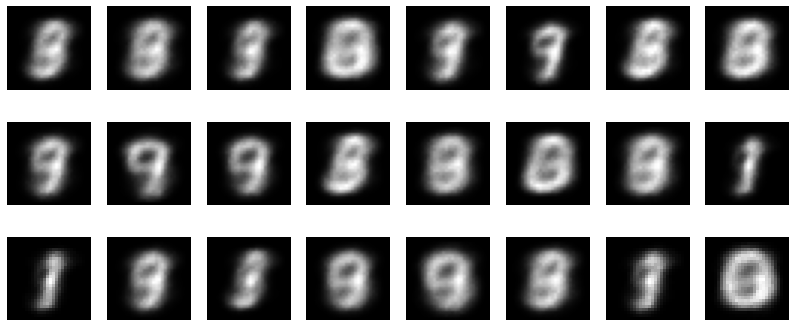

In [7]:
from matplotlib import pyplot as plt
ims = sample(24) #generiamo 24 immagini
i=1
#stampiamoli in una griglia mediante subplot
plt.figure(figsize=(14,6))
for im in ims:
    plt.subplot(3,8,i)
    i+=1
    plt.imshow(sample(1),cmap='gray')
    plt.axis('off')
plt.show()

Un variational autoencoder apprende uno spazio latente in cui ciascun elemento corrisponde a un plausibile elemento dello spazio delle immagini. Lo spazio latente ha una caratteristica di continuità che fa sì che effettuando una interpolazione tra due diversi codici, si ottengano delle immagini che "si trasformano" gradualmente dall'immagine di partenza a quella di arrivo. Vediamo un esempio in cui scegliamo due codici casuali e interpoliamo tra i due mediante combinazioni lineari:

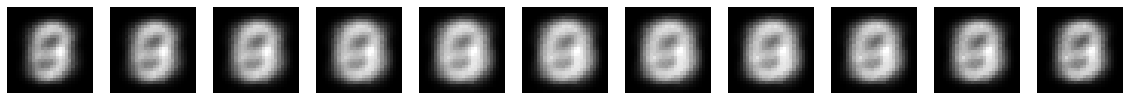

In [8]:
#generiamo due codici
z1 = torch.randn(128)
z2 = torch.randn(128)

plt.figure(figsize=(20,4))
i=1
#generiamo 11 coppie di coefficienti (alpha, 1-aplha)
#che variano da 0 a 1
for alpha in np.arange(0,1.1,0.1):
    #combinazione lineare
    z = z1*alpha + (1-alpha)*z2
    #generazione dell'immagine
    im = mnist_fc_vae.decoder(z).detach().cpu().numpy().reshape(28,28)
    #plot
    plt.subplot(1,11,i)
    i+=1
    plt.imshow(im, cmap='gray')
    plt.axis('off')

E' anche possibile interpolare tra i codici relativi a due cifre del dataset. Per fare questo, scegliamo le medie estratte dall'encoder come codici corrispondenti alle cifre:

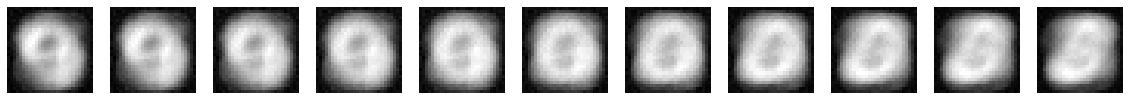

In [9]:
#estraiamo i due codici
z1, _ = mnist_fc_vae.encoder(mnist_train_dataset[0][0])
z2, _ = mnist_fc_vae.encoder(mnist_train_dataset[2][0])

plt.figure(figsize=(20,4))
i=1
#generiamo 11 coppie di coefficienti (alpha, 1-aplha)
#che variano da 0 a 1
for alpha in np.arange(0,1.1,0.1):
    #combinazione lineare
    z = z1*alpha + (1-alpha)*z2
    #generazione dell'immagine
    im = mnist_fc_vae.decoder(z).detach().cpu().numpy().reshape(28,28)
    #plot
    plt.subplot(1,11,i)
    i+=1
    plt.imshow(im, cmap='gray')
    plt.axis('off')

## 1.2 VAE per unsupervised representation learning

Possiamo utilizzare un VAE così come un semplice autoencoder per fare representation learning. In particolare, utilizzeremo le medie estratte dall'encoder come rappresentazioni delle immagini in input. Seguendo lo schema visto nel laboratorio sugli autoencoder, rappresentiamo le immagini col modello allenato e plottiamo le rappresentazione mediante proiezione TSNE:

In [10]:
def extract_codes(model, loader):
    codes, labels = [], []
    for batch in loader:
        x = batch[0]
        code, *_ = model(x)
        code = code.detach().to('cpu').numpy()
        labels.append(batch[1])
        codes.append(code)
    return np.concatenate(codes), np.concatenate(labels)

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


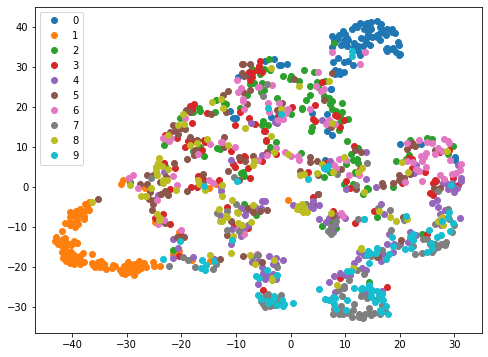

In [11]:
codes, labels = extract_codes(mnist_fc_vae.encoder, mnist_test_loader)
selected_codes = np.random.choice(len(codes),1000)
codes = codes[selected_codes]
labels = labels[selected_codes]

tsne = TSNE(2)
codes_tsne=tsne.fit_transform(codes)

from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne[labels==c, 0], codes_tsne[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

# 2. Generative Adversarial Networks

Le Generative Adversarial Networks (GAN) sono una classe di modelli che, in maniera simile ai Variational Autoencoder, permettono di modellare la distribuzione dei dati $p_{data}(x)$ in modo da generare esempi che verosimilmente appartengono alla distribuzione $\hat x \sim p_{data}(x)$. Una GAN è composta di due elementi: un generatore e un discriminatore. Il generatore $G$ è una rete neurale capace di generare elementi $\hat x$ a partire da un vettore $z$ appartenente a una distribuzione nota (generalmente scegliamo $z \sim N(0,1)$: $\hat x = G(z), z \in N(0,1)$. In questo, il generatore è del tutto simile al decoder visto nel caso dei VAE. Il discriminatore è invece un classificatore che prende in input un elemento $\overline x$ e valuta qualora esso sia un esempio "vero", ovvero un campione realmente estratto dal dataset, o un esempio "finto", ovvero un esempio generato dal generatore.

Una GAN viene allenata mediante un processo che mira a ottimizzare i pesi del discriminatore $D$ in modo da migliorarne le performance (ovvero i modo che esso sia bravo a distinguere elementi veri da elementi generati) e al contempo ottimizzare i pesi del generatore $G$ in modo che esso generi elementi indistinguibili da quelli reali, diminuendo dunque le performance del discriminatore. Le due reti $D$ e $G$ giocano dunque un gioco "min-max" con funzione valore $V(D,G)$ come mostrato di seguito:

$$ \min_G \max_D V(D,G) = \mathbb{E}_{x \sim p_{data}(x)[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)[\log (1-D(G(z)))] }}  $$

dove $\mathbb{E}$ rappresenta una expectation, $p_{data}(x)$ è la probabilità dei dati che vogliamo studiare, e $p_{z}(z)$ è la probabilità nota delle variabili latenti.

### Training
Ottimizzare $D$ e $G$ come mostrato sopra non è banale in quanto il criterio usato per migliorare le perfomance di $G$ peggiorerà quelle di $D$ e viceversa. Si procede dunque ottimizzando separatamente $D$ e $G$ in una procedura di ottimizzazione alternata in cui $D$ viene allenato per un certo numero di iterazioni, dopo di che $G$ viene ottimizzato per un certo numero di iterazioni e si procede in ciclo finché il "gioco" raggiunge uno stallo (una situazione simile a quella descritta dall'equilibrio di Nash) e non è più possibile ottimizzare i due modelli.

In questa procedura alternata, il discriminatore viene allenato campionando $m$ vettori latenti ${z^{i}}_{i=1}^m$ e $m$ elementi reali ${x^{i}}_{i=1}^m$ e ottimizzando la binary cross-entropy loss:

$$\mathcal{L}_D = - \frac{1}{m} \sum_{i=1}^m [\log D(x^{(i) + \log (1-D(G(z^{i})))]}$$

Si noti che questa loss dipende solo da $D$, quindi quando si ottimizza la funzione sopra, i pesi di $G$ non vengono aggiornati.

Il generatore viene allenato campionando $m$ vettori latenti ${z^{i}}_{i=1}^m$ e ottimizzando la binary cross-entropy loss anche in questo caso:

$$\mathcal{L}_G = - \frac{1}{m} \sum_{i=1}^m \log (1-D(G(z^{i})))$$

Si noti che in questo caso vengono aggiornati solo i pesi di $G$, mentre quelli di $D$ restando costanti.

L'immagine seguente mostra uno schema del funzionamento di una GAN

$\phi_g$ e $\phi_d$ rappresentano i parametri del generatore e del discriminatore.

Sorgente:https://it.wikipedia.org/wiki/Rete_generativa_avversaria#/media/File:Rete_generativa_avversaria.png
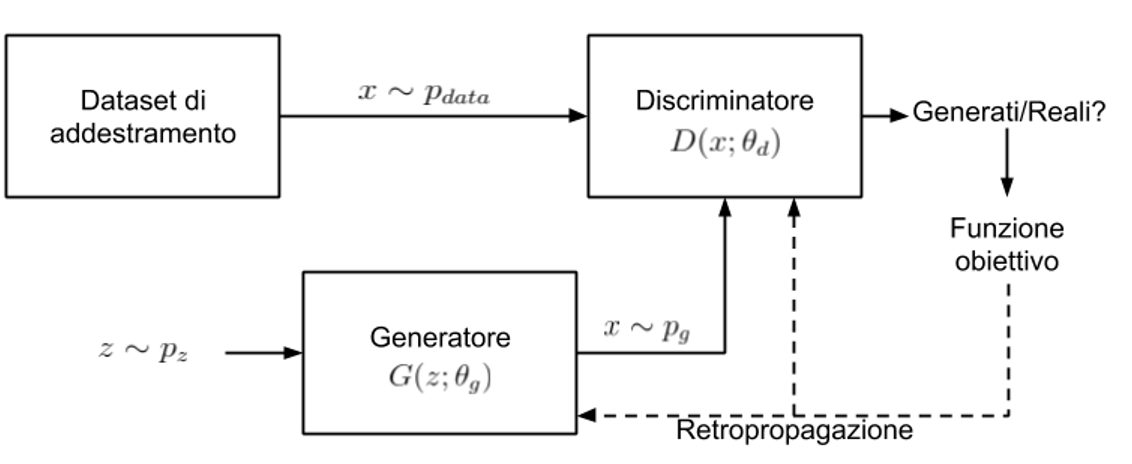

### Implementazione
Vediamo adesso come costruire il modello di una GAN. Costruiremo una GAN basata su convoluzioni (Deep Convolutional GAN - DCGAN) e la testeremo su MNIST per uniformità rispetto agli esempi visti in precedenza. Seguiremo l'implemntazione proposta qui: https://github.com/nocotan/pytorch-lightning-gans/blob/master/models/dcgan.py. Iniziamo definendo il generatore:

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        # dimensione di partenza. Se la dimensione in output è 32 x 32, questa sarà  8 x 8
        self.init_size = img_shape[1] // 4

        # usiamo un layer lineare per proiettare il vettore latente su
        # un vettore di dimensione 128 * 8 * 8
        # useremo una view per trasformare questo vettore in una mappa 128 x 8 x 8 nel metodo forward
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            # usiamo le batch normalization
            # per accelerare il training
            nn.BatchNorm2d(128),
            # questo layer fa upsampling della mappa 8x8 e la fa diventare 16x16
            nn.Upsample(scale_factor=2),
            #convoluzione con padding=1 per mantenere la stessa dimensione 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True), #usiamo le leaky relu invece delle relu
            #queste funzionano meglio con le GAN
            nn.Upsample(scale_factor=2), #16x16 -> 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #layer finale di convluzioni che fa passare da 64 canali a 3
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        out = self.l1(z)
        #la view serve per passare da un vettore a una mappa di feature
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Definiamo adesso il discriminatore:

In [13]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        #definisce un "blocco del discriminatore"
        def discriminator_block(in_feat, out_feat, bn=True):
            #questo include una convoluzione, una LeakyReLU, e un dropout
            block = [nn.Conv2d(in_feat, out_feat, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                #se richiesto inseriamo la batch normalization
                block.append(nn.BatchNorm2d(out_feat, 0.8))
            return block

        #costruisce il modulo principale
        #solo il primo layer ha la batch normalization
        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # alla fine delle convoluzioni avremo una mappa a dimensionalità ridotta
        ds_size = img_shape[1] // 2 ** 4
        #usiamo un layer lineare e un sigmoide per ottenere la classificazione
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        #la view serve per passare dalla mappa di feature al vettore linearizzato
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

Definiamo quindi il modulo di Lightning DCGAN. Oltre ai metodi visti finora, ne introdurremo uno nuovo `train_dataloader` che permette di specificare come costruire il dataloader di training:

In [14]:
class DCGAN(LightningModule):

    def __init__(self,
                latent_dim: int = 100,
                lr: float = 0.0002,
                b1: float = 0.5,
                b2: float = 0.999,
                 batch_size: int = 64, **kwargs):
        super().__init__()
        #questo metodo conserva una copia degli iperparametri alla quale accedere in seguito
        self.save_hyperparameters()

        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size

        # la dimensione dell'immagine in input# networks
        img_shape = (1, 32, 32)
        #costruisce generatore e discriminatore 
        self.generator = Generator(latent_dim=self.latent_dim, img_shape=img_shape)
        self.discriminator = Discriminator(img_shape=img_shape)

        #conserva un insieme di codici di validazione da tenere fissi
        #per monitorare l'evoluzione della rete
        self.validation_z = torch.randn(50, self.latent_dim)

        #un esempio di input del modello
        self.example_input_array = torch.zeros(2, self.latent_dim)

    def forward(self, z):
        #in fase di forward usiamo solo il generatore
        return self.generator(z)
    
    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2

        # per implementare la procdura di ottimizzazione alternata,
        # definiamo due ottimizzatori invece di uno
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        # restituiamo dunque una lista contenente i due ottimizzatori
        # la lista vuota indica gli scheduler, che non specifichiamo
        return [opt_g, opt_d], []

    def training_step(self, batch, batch_idx, optimizer_idx):
        # questo metodo verrà chiamato due volte, una per ogni ottimizzatore definito
        # optimizer_idx permetterà di distinguere tra i due ottimizzatori
        imgs, _ = batch #scartiamo le etichette del batch

        # campioniamo dei vettori di rumore random
        # questi ci serviranno sia per il training del generatore 
        # che per quello del discriminatore
        z = torch.randn(imgs.shape[0], self.latent_dim)
        # ci assicuriamo che il "tipo" sia lo stesso delle immagini (es. entrambi sono su GPU)
        z = z.type_as(imgs)

        # primo ottimizzatore: alleniamo il generatore
        if optimizer_idx == 0:

            # generiamo le immagini dai vettori random
            self.generated_imgs = self(z)

            # prendiamo le prime 8 immagini generate e le loggiamo
            sample_imgs = self.generated_imgs[:8]
            grid = torchvision.utils.make_grid(sample_imgs, nrow=10)
            self.logger.experiment.add_image('generated_images', grid, self.global_step)

            # definiamo le etichette delle immagini che abbiamo generato
            # durante il training del generatore, vogliamo che vengano viste come "real" (etichetta 1)
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs) #mettiamole sul device corretto cambiandone il tipo

            # loss del generatoreetichette predette per le immagini generate
            g_loss = F.binary_cross_entropy(self.discriminator(self(z)), valid)

            self.log('generator/loss', g_loss.item())

            # restituiamo la loss più qualche statistica per la visualizzazione
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # allenamento del discriminatore# train discriminator
        if optimizer_idx == 1:
            # etichette delle immagini reali in imgs
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # otteniamo le predizioni per le immagini reali
            predicted_real_labels = self.discriminator(imgs)

            # loss per classificare bene le immagini reali
            real_loss = F.binary_cross_entropy(predicted_real_labels, valid)

            # adesso dobbiamo ripetere il processo per i fake
            # etichette fake: tutti zeri# how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            # generiamo le predizioni per le immagini fake
            predicted_fake_labels = self(z).detach()
            # loss per fake
            fake_loss = F.binary_cross_entropy(
                self.discriminator(predicted_fake_labels), fake)
            
            # calcoliamo la loss del discriminatore come media fra le due
            d_loss = (real_loss + fake_loss) / 2

            # log della loss del discriminatore
            self.log('discriminator/loss', d_loss.item())
            
            # calcoliamo l'accuracy fake e real
            d_fake_acc = (predicted_fake_labels<=0.5).float().mean()
            d_real_acc = (predicted_real_labels>0.5).float().mean()
            #accuracy finale
            d_acc = (d_fake_acc + d_real_acc)/2
            
            # log
            self.log('discriminator/fake_acc', d_fake_acc.item())
            self.log('discriminator/real_acc', d_real_acc.item())
            self.log('discriminator/overall_acc', d_acc.item())

            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output


    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((32, 32)), #resize a 32x32 -> la rete è stata progettata per questa dimensione
            transforms.ToTensor(),
        ])

        dataset = MNIST(os.getcwd(), train=True, download=True, transform=transform)
        return DataLoader(dataset, batch_size=self.batch_size)

    def on_epoch_end(self):
        #alla fine dell'epoca, generiamo le immagini corrispondenti agli z di validazione
        z = self.validation_z.to(self.device)

        # generiamo le immagini# log sampled images
        sample_imgs = self(z)
        #facciamo log
        grid = torchvision.utils.make_grid(sample_imgs, nrow=10)
        self.logger.experiment.add_image('validation_images', grid, self.global_step)

Ora che il modello è definito, passiamo all'allenamento del modello:

In [15]:
mnist_gan = DCGAN()
logger = TensorBoardLogger("tb_logs", name="mnist_gan")
trainer = pl.Trainer(gpus=NUM_GPU, logger=logger, max_epochs=NUM_EPOCHS)

trainer.fit(mnist_gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type          | Params | In sizes | Out sizes     
----------------------------------------------------------------------------
0 | generator     | Generator     | 1.0 M  | [2, 100] | [2, 1, 32, 32]
1 | discriminator | Discriminator | 98.1 K | ?        | ?             
----------------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.592     Total estimated model params size (MB)


9913344it [00:04, 2107539.13it/s]                             


Extracting /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw/train-images-idx3-ubyte.gz to /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw



29696it [00:00, 2997546.49it/s]          


Extracting /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw



1649664it [00:00, 2433164.50it/s]                             


Extracting /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw



5120it [00:00, 6329159.00it/s]          
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Extracting /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/danilo/GitHub/deep-learning/lab02/MNIST/raw

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s] 

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Epoch 1:  85%|████████▍ | 793/938 [14:49<02:42,  1.12s/it, loss=0.706, v_num=0]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Una volta allenato il modello, possiamo utilizzarlo per generare una serie di immagini nuove:

In [16]:
def sample(n):
    #passo 1: generiaom n vettori latenti che seguono la distribuzione normale
    z = torch.randn((n, 100))
    #passo 2: convertiamo gli n vettori in immagini mediante il decoder del VAE
    images = mnist_gan(z)
    images = [x.reshape(32,32).detach().cpu().numpy() for x in images]
    if n==1:
        return images[0]
    else:
        return images

Adesso utilizziamo la funzione definita sopra per generare delle immagini:

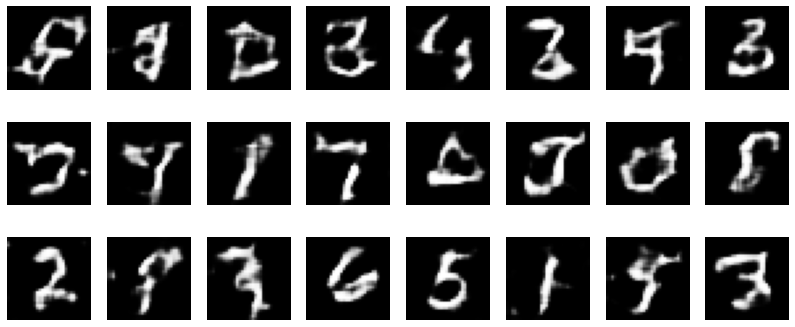

In [17]:
from matplotlib import pyplot as plt
ims = sample(24) #generiamo 24 immagini
i=1
#stampiamoli in una griglia mediante subplot
plt.figure(figsize=(14,6))
for im in ims:
    plt.subplot(3,8,i)
    i+=1
    plt.imshow(sample(1),cmap='gray')
    plt.axis('off')
plt.show()

Vediamo anche un esempio di interpolazione tra due immagini generate:

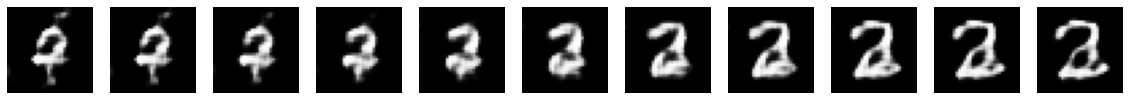

In [18]:
#generiamo due codici
z1 = torch.randn(1,100)
z2 = torch.randn(1,100)

plt.figure(figsize=(20,4))
i=1
#generiamo 11 coppie di coefficienti (alpha, 1-aplha)
#che variano da 0 a 1
for alpha in np.arange(0,1.1,0.1):
    #combinazione lineare
    z = z1*alpha + (1-alpha)*z2
    #generazione dell'immagine
    im = mnist_gan(z).detach().cpu().numpy().reshape(32,32)
    #plot
    plt.subplot(1,11,i)
    i+=1
    plt.imshow(im, cmap='gray')
    plt.axis('off')